In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
import imageio
import cv2
import os
import IPython
from IPython.display import Image

In [3]:
import mediapipe as mp

In [4]:
import pickle
import random
import augmentors as va
import traceback
from itertools import chain
from tqdm.notebook import tqdm

In [138]:
CLASS_NAMES = ['xiaoheizi', 'ikun']
SEQ_LENGTH = 75
COMPLEX_MODE = True
CLASS_NUM = 2
BATCH_SIZE = 4
INPUT_SHAPE = (SEQ_LENGTH, 2) if not COMPLEX_MODE else (SEQ_LENGTH, 33*2)
# Mediapipe model config
MODEL_COMPLEXITY = 2
ENABLE_SEGMENTATION = False
MIN_DETECTION_CONFIDENCE = 0.5
MIN_TRACKING_CONFIDENCE = 0.5

数据集预处理：IKUN样本量稀少，需做数据增强，手段包括：（1）随机画面裁剪；（2）轻度旋转；（3）镜像；（4）跳帧；（5）随机帧位置裁剪

In [25]:
def augmentation(video_path, target_path, is_random_crop: bool):
    """https://github.com/okankop/vidaug"""
    
    # step1: extract original frames and video info (shape, fps)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error Opening video File")
        raise IOError
    
    # get fps
    (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
    if int(major_ver)  < 3 :
        fps = cap.get(cv2.cv.CV_CAP_PROP_FPS)
        # print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
    else :
        fps = cap.get(cv2.CAP_PROP_FPS)
        # print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
    
    # get frame shape
    frame_width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float `width`
    frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float `height`
    
    # read frames
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
        else:
            break
    cap.release()
    
    # step2: augmentation
    
    crop_width, crop_height = map(lambda x: int(x * 0.8), [frame_width, frame_height])
    trans_x, trans_y = map(lambda x: int(x * 0.2), [frame_width, frame_height])
    deg = random.randint(1,5)
    
    seq = va.Sequential([
        va.RandomTranslate(x=trans_x, y=trans_y),
        # va.RandomRotate(degrees=deg),  # sometime return black frames
        va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(size=(crop_height, crop_width)),
        va.HorizontalFlip(),
        # va.Pepper(95)  # too large
    ])
    
#     if fps > 25:
#         seq.add(va.Downsample(ratio=25/fps))
#     elif fps < 25:
#         seq.add(va.Upsample(ratio=fps/25))
#     else:
#         pass
    
    frames_aug = seq(frames)
    size = np.shape(frames_aug[0])
    # print(frames_aug[0].dtype)
    # print(size)
    
    # step3: rewrite video
    codec = cv2.VideoWriter_fourcc(*'mp4v')  # cv2.VideoWriter_fourcc('M','J','P','G')  # 
    out = cv2.VideoWriter(target_path, codec, fps, (size[1], size[0]))
    
    for aug_frame in frames_aug:
        out.write(aug_frame)
    
    out.release()

测试数据增强效果

In [26]:
vid_path = 'tieshankao.mp4'
augmentation(vid_path, target_path='tieshankao_aug.mp4', is_random_crop=True)

In [27]:
# 对原始IKUN视频目录下的文件进行预处理
origin_video_dir = 'F:/A_Projects/C1_CV_Projects/Projects1_TelloDroneDetection/TelloDroneDetection/TelloDroneDetection/training/ikun_video_cut'
aug_video_dir = 'F:/A_Projects/C1_CV_Projects/Projects1_TelloDroneDetection/TelloDroneDetection/TelloDroneDetection/training/dataset/ikun'

for filename in tqdm(os.listdir(origin_video_dir)):
    file_path = os.path.join(origin_video_dir, filename)
    target_path = os.path.join(aug_video_dir, 'aug_' + filename)
    target_path_more = os.path.join(aug_video_dir, 'aug2_' + filename)
    
    try:
        augmentation(file_path, target_path, is_random_crop=True)
        augmentation(file_path, target_path, is_random_crop=False)
    except Exception as e:
        print(f'file augmentation error，filename: {filename}.\n')
        traceback.print_exc()
        print('\n')

  0%|          | 0/55 [00:00<?, ?it/s]

file augmentation error，filename: 20sui.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: baishi.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: banji.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: cesuo.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: diangong.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: dianxin.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: duibuqi.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: erciyuanzhenren.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: genzhexue.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: guanmen.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: gudai.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: haixiu.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: haiyouren.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: heisi.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: huashen.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: jiewu.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: jigongzai.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: jixie.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: jixie2.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: kaichemen.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: karsa.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: kfc.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: lanqiubaobei.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: lanqiuchang.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: lee1.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: lee10.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: lee11.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: lee2.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: lee3.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: lee4.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: lee5.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: lee6.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: lee7.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: lee8.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: lee9.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: meishaonv.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: nilong.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: nvban.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: nvikun.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: nvlianxisheng.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: shenzhi2.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: sop1.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: sop2.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: tangxiaov.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: tieshankao.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: tongxue.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: xiang.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: xianzaiqiang.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: xiaoikun.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: xiaoxiaozhiyin.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: xuxu.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: yuanban.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: zhenghuo.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: zhuiwo.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


file augmentation error，filename: zixue.mp4.





Traceback (most recent call last):
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\203793542.py", line 12, in <module>
    augmentation(file_path, target_path, is_random_crop=False)
  File "C:\Users\mechl\AppData\Local\Temp\ipykernel_1576\3418852206.py", line 42, in augmentation
    va.RandomCrop(size=(crop_height, crop_width)) if is_random_crop else va.CenterCrop(),
TypeError: __init__() missing 1 required positional argument: 'size'


In [113]:
pose = mp.solutions.pose.Pose(model_complexity=MODEL_COMPLEXITY, 
                              enable_segmentation=ENABLE_SEGMENTATION,
                              min_detection_confidence=MIN_DETECTION_CONFIDENCE,
                              min_tracking_confidence=MIN_TRACKING_CONFIDENCE)

In [114]:
def detect_landmark_fp(frame, mpose_model):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = mpose_model.process(image)
    return result

In [115]:
def extract_feature(vid_path, mpose_model, complex_mode=False, seq_min_nums=SEQ_LENGTH):
    """
    complex_mode=True将保留所有33个关键点，否则只提取计算的肩关节中间点（1个）。
    """
    
    reserved_landmark_ids = list(range(33))
    ret = 0
    feature = None
    
    cap = cv2.VideoCapture(vid_path)
    if not cap.isOpened():
        print("Error Opening video File")
        raise IOError

    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
        else:
            break
            
    frames_cnt = len(frames)
    cap.release()
    cv2.destroyAllWindows()
    
    landmarks = [detect_landmark_fp(frame, mpose_model).pose_landmarks for frame in frames]
    valid_landmarks = [[[landmark.x, landmark.y] for landmark in np.array(item.landmark)[reserved_landmark_ids]] for item in landmarks if item is not None]  # (N, 33, 2)
    
    if complex_mode:
        valid_samples = [list(chain.from_iterable(item)) for item in valid_landmarks]
    else:
        valid_samples = [[(item[11][0] + item[12][0])/2, (item[11][1] + item[12][1])/2] for item in valid_landmarks]
    
    if len(valid_samples) >= SEQ_LENGTH:
        ret = 1
        begin = np.floor((len(valid_samples) - SEQ_LENGTH)/2).astype(int)
        feature = valid_samples[begin:(begin + SEQ_LENGTH)]
    
    return ret, feature

测试特征提取函数

In [116]:
video_pth = 'tieshankao.mp4'
ret, feature = extract_feature(video_pth, pose, complex_mode=True, seq_min_nums=SEQ_LENGTH)
if ret:
    print(len(feature), np.shape(feature), feature)

60 (60, 66) [[0.5879687070846558, 0.3703956604003906, 0.576353132724762, 0.3594183921813965, 0.5690643191337585, 0.3586345314979553, 0.5615498423576355, 0.35799065232276917, 0.5937156081199646, 0.36031463742256165, 0.5988197326660156, 0.3600320518016815, 0.6036208868026733, 0.35954582691192627, 0.5463752746582031, 0.3614049553871155, 0.6010223627090454, 0.3616423010826111, 0.5754081010818481, 0.3785948157310486, 0.5951793193817139, 0.38003110885620117, 0.44560399651527405, 0.410759299993515, 0.6641756296157837, 0.42344921827316284, 0.37918826937675476, 0.5045405030250549, 0.7060667276382446, 0.524377703666687, 0.46247535943984985, 0.5534948706626892, 0.6275437474250793, 0.5664335489273071, 0.48069339990615845, 0.5697324275970459, 0.601303219795227, 0.5850774049758911, 0.4920433759689331, 0.5612290501594543, 0.5922849178314209, 0.5773671865463257, 0.48935723304748535, 0.5542972087860107, 0.5991454720497131, 0.5700910687446594, 0.4781017601490021, 0.597322404384613, 0.6036872267723083, 0

In [117]:
def load_dataset(dataset_dir, complex_mode):
    """
    :param dataset_dir: root_dir -> sub_dir -> video_paths
    :return:
    """
    dir_names = [name for name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, name))]
    assert set(dir_names) == set(CLASS_NAMES)
    
    samples_num_list = []
    for sub_dir in [os.path.join(dataset_dir, name) for name in dir_names]:
        samples_num_list.append(len(os.listdir(sub_dir)))
    min_samples_num = min(samples_num_list)
    print(f"minimun samples number: {min_samples_num}")

    features = []
    labels_ids = []
    for name in tqdm(dir_names, desc="Iterate video rootdir: "):
        sub_dir = os.path.join(dataset_dir, name)
        labels_id = CLASS_NAMES.index(name)
        
        # random shuffle files and get last min_samples_num elements
        filenames = os.listdir(sub_dir)
        random.shuffle(filenames)
        filenames = filenames[:min_samples_num]
        
        success_cnt = 0
        for filename in tqdm(filenames, desc=f"Iterate subdir '{name}': "):
            vid_path = os.path.join(sub_dir, filename)
            ret, feature = extract_feature(vid_path, pose, complex_mode)
            if ret:
                features.append(feature)
                labels_ids.append(labels_id)
                 
                success_cnt +=1
            else:
                print(f"Error extracting, filename is {filename}.")
            
        print(f"subdir({sub_dir}) files number: {len(filenames)}; successfuly extracted files number: {success_cnt}.")
        

    return features, labels_ids

测试样本质量

In [139]:
dataset_dir = 'F:/A_Projects/C1_CV_Projects/Projects1_TelloDroneDetection/TelloDroneDetection/TelloDroneDetection/training/dataset'

cache_path = 'dataset75.pkl'
if not os.path.exists(cache_path):
    dataset_features, dataset_labels = load_dataset(dataset_dir, complex_mode=True)
    with open(cache_path, 'wb') as f:
        pickle.dump((dataset_features, dataset_labels), f)
        print("successfuly cached.")
else:
    with open(cache_path, 'rb') as f:
        dataset_features, dataset_labels = pickle.load(f)
        print("successfuly loaded.")

successfuly loaded.


In [140]:
# step1: format array shape for model feeding
features_arr = np.array(dataset_features)
labels_arr = np.expand_dims(np.array(dataset_labels), axis=1)
# print(np.shape(features_arr), np.shape(labels_arr))

# step2: split to tring-val
x_train, x_test, y_train, y_test = train_test_split(features_arr, labels_arr, test_size=0.05, random_state=20, shuffle=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(226, 75, 66) (12, 75, 66) (226, 1) (12, 1)


In [141]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [144]:
# Build Model
model = Sequential([
    layers.Input(shape=INPUT_SHAPE),
    layers.GRU(32, return_sequences=False),
    layers.Dense(len(CLASS_NAMES), activation="softmax")
])
model.compile(
    optimizer=optimizers.Adam(0.001), 
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
)
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_22 (GRU)                (None, 32)                9600      
                                                                 
 dense_24 (Dense)            (None, 2)                 66        
                                                                 
Total params: 9,666
Trainable params: 9,666
Non-trainable params: 0
_________________________________________________________________


In [145]:
# Train Model
filepath = "./saved_model/ikun_classifier"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_accuracy', save_weights_only=True, save_best_only=True, verbose=1
)

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=45,
    callbacks=[checkpoint],
)

Epoch 1/45
7/8 [=========================>....] - ETA: 0s - loss: 0.6659 - accuracy: 0.5804
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to ./saved_model\ikun_classifier
8/8 [==============================] - 4s 99ms/step - loss: 0.6657 - accuracy: 0.5796 - val_loss: 0.6782 - val_accuracy: 0.6667
Epoch 2/45
7/8 [=========================>....] - ETA: 0s - loss: 0.6588 - accuracy: 0.6562
Epoch 2: val_accuracy did not improve from 0.66667
8/8 [==============================] - 0s 24ms/step - loss: 0.6587 - accuracy: 0.6549 - val_loss: 0.6843 - val_accuracy: 0.5833
Epoch 3/45
7/8 [=========================>....] - ETA: 0s - loss: 0.6414 - accuracy: 0.6607
Epoch 3: val_accuracy did not improve from 0.66667
8/8 [==============================] - 0s 27ms/step - loss: 0.6406 - accuracy: 0.6637 - val_loss: 0.6841 - val_accuracy: 0.5833
Epoch 4/45
6/8 [=====================>........] - ETA: 0s - loss: 0.6304 - accuracy: 0.6927
Epoch 4: val_accuracy did not improve from 0.66

8/8 [==============================] - 0s 13ms/step - loss: 0.2624 - accuracy: 0.9071 - val_loss: 0.5035 - val_accuracy: 0.7500
Epoch 31/45
8/8 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.8540
Epoch 31: val_accuracy did not improve from 0.91667
8/8 [==============================] - 0s 12ms/step - loss: 0.3150 - accuracy: 0.8540 - val_loss: 0.2682 - val_accuracy: 0.9167
Epoch 32/45
8/8 [==============================] - ETA: 0s - loss: 0.2713 - accuracy: 0.8894
Epoch 32: val_accuracy did not improve from 0.91667
8/8 [==============================] - 0s 12ms/step - loss: 0.2713 - accuracy: 0.8894 - val_loss: 0.3104 - val_accuracy: 0.8333
Epoch 33/45
7/8 [=========================>....] - ETA: 0s - loss: 0.2606 - accuracy: 0.8839
Epoch 33: val_accuracy did not improve from 0.91667
8/8 [==============================] - 0s 12ms/step - loss: 0.2589 - accuracy: 0.8850 - val_loss: 0.2924 - val_accuracy: 0.8333
Epoch 34/45
8/8 [==============================] - ET

In [131]:
# Validate Model
model.load_weights(filepath)
loss, accuracy = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 27ms/step - loss: 0.4504 - accuracy: 0.8667


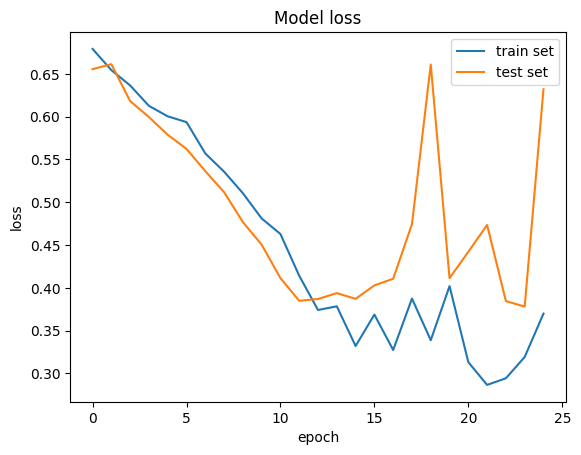

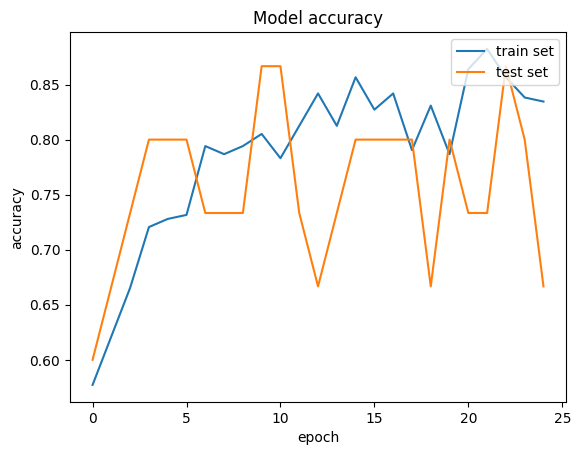

In [132]:
# Training Result Plotting

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train set', 'test set'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train set', 'test set'], loc='upper right')

In [133]:
model.save('ikun_model')

INFO:tensorflow:Assets written to: ikun_model\assets


INFO:tensorflow:Assets written to: ikun_model\assets
